## Import Libraries

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [1]:
import torch

if torch.cuda.is_available():
    torch.cuda.init()  # Explicitly initialize CUDA


In [2]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline  
import glob  # Filename pattern matching
import random  
import cv2  # Computer vision
from PIL import Image  # Image processing
from sklearn.utils import resample
import shutil

import torch  
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import load_model
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import binary_dilation
from torchvision import transforms as tt


/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
2025-04-18 08:15:21.643886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744964121.837611      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744964121.901138      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise CPU
print("Using {} device".format(device))  # Print the selected device

Using cuda device


## Load files path in a dataframe

In [4]:
ROOT_PATH = '../input/lgg-mri-segmentation/kaggle_3m/'

# Using glob.glob to collect paths of all mask files in subdirectories 
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining a function diagnosis(mask_path) that returns 1 
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
...,...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [5]:
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                         "mask_path": mask_files,
                         "diagnosis": [diagnosis(x) for x in mask_files]})


In [6]:
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [7]:
non_tumor_df = files_df[files_df["diagnosis"] == 0]
tumor_df = files_df[files_df["diagnosis"] == 1]

non_tumor_df_sampled = resample(non_tumor_df, replace=False, n_samples=1371, random_state=42)
tumor_df_sampled = resample(tumor_df, replace=False, n_samples=1371, random_state=42)

balanced_df = pd.concat([tumor_df_sampled, non_tumor_df_sampled]).sample(frac=1).reset_index(drop=True)

In [8]:
# Print new dataset balance
print(f"Balanced Dataset - Tumor Cases: {len(balanced_df[balanced_df['diagnosis'] == 1])}")
print(f"Balanced Dataset - Non-Tumor Cases: {len(balanced_df[balanced_df['diagnosis'] == 0])}")

# Move the selected images & masks to a new folder
os.makedirs("balanced_images", exist_ok=True)
os.makedirs("balanced_masks", exist_ok=True)

for _, row in balanced_df.iterrows():
  shutil.copy(row["image_path"], f"balanced_images/{os.path.basename(row['image_path'])}")
  shutil.copy(row["mask_path"], f"balanced_masks/{os.path.basename(row['mask_path'])}")

Balanced Dataset - Tumor Cases: 1371
Balanced Dataset - Non-Tumor Cases: 1371


In [9]:
print(len(os.listdir("balanced_images")))  # Should be 1371 + 1373 = 2744
print(len(os.listdir("balanced_masks")))   # Should also be 274

2742
2742


In [10]:
# Use the balanced dataset after downsampling
train_df, val_df = train_test_split(balanced_df, stratify=balanced_df['diagnosis'], test_size=0.1, random_state=0)

# Reset index after splitting
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Further split training data to create a test set
train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)

# Reset index again
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#  Print the new dataset distribution
print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (2096, 3)
Val: (275, 3)
Test: (371, 3)


## Viewing the dataset

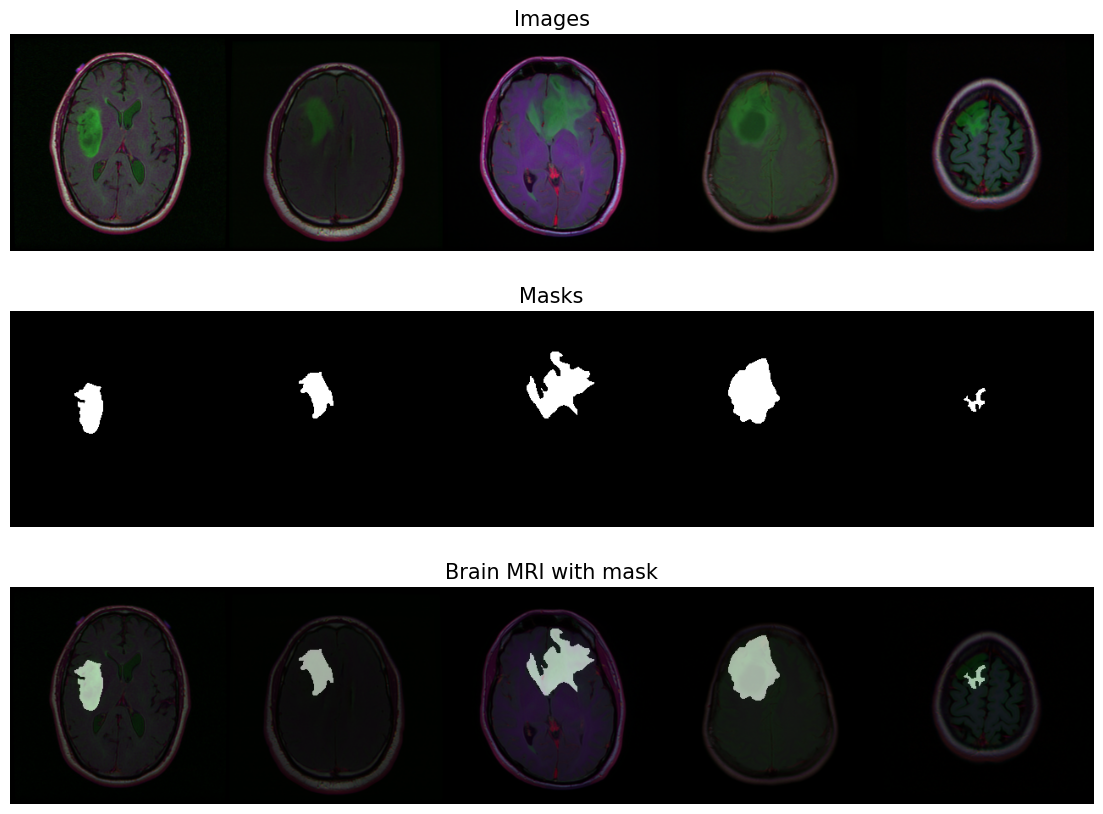

In [11]:

images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

# Prepare the images and masks
images, masks = [], []
df_positive = train_df[train_df['diagnosis'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)

# Reverse the order of images and masks
images = np.array(images[4::-1])
masks = np.array(masks[4::-1])

# Concatenate the images and masks horizontally
images_concat = np.hstack(images)
masks_concat = np.hstack(masks)

# Plot the images, masks, and overlays
fig = plt.figure(figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 1), axes_pad=0.6)

grid[0].imshow(images_concat)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')

grid[1].imshow(masks_concat)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')

grid[2].imshow(images_concat)
grid[2].imshow(masks_concat, alpha=0.6)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

plt.show()

In [12]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[idx, 1], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)  # Add channel dimension

        mask = mask.float() / 255.0  # Normalize mask to [0, 1]
        return image, mask

In [13]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = val_transform

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [15]:
def dataset_info(dataset): 
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [16]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 2096
Sample-40 Image size: torch.Size([3, 256, 256]), Mask: torch.Size([1, 256, 256])

Validation dataset:
Size of dataset: 275
Sample-11 Image size: torch.Size([3, 256, 256]), Mask: torch.Size([1, 256, 256])

Test dataset:
Size of dataset: 371
Sample-12 Image size: torch.Size([3, 256, 256]), Mask: torch.Size([1, 256, 256])



## Creating Dataloaders

In [17]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

In [18]:
# Fetch a batch of data (images and masks) from the training DataLoader (`train_dl`).
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 256, 256])


In [19]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        att = self.conv(x)
        att = self.sigmoid(att)
        return x * att

In [20]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        """
        A single conv -> GroupNorm -> ReLU -> (optional upsample) block.
        """
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x


class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        """
        Stack of ConvReluUpsample blocks with optional upsampling.
        n_upsamples determines how many times upsampling happens.
        """
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        for _ in range(1, n_upsamples):
            blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [21]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class EnhancedFPN(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        
        # Encoder
        self.conv1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)

        # Top-down pathway with attention
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1)
        self.att5 = AttentionBlock(256, 256)
        
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1)
        self.att4 = AttentionBlock(256, 256)
        
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1)
        self.att3 = AttentionBlock(256, 256)
        
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1)
        self.att2 = AttentionBlock(256, 256)

        # Smoothing
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Feature fusion
        self.fusion_conv = DoubleConv(256 * 4, 256)

        # Final segmentation head
        self.final_conv = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=1)
        )

    def _upsample_add(self, x, y):
        return F.interpolate(x, size=y.shape[2:], mode='bilinear', align_corners=True) + y

    def forward(self, x):
        # Bottom-up pathway
        c1 = self.conv1(x)      # 1/1
        p1 = self.pool1(c1)     # 1/2
        c2 = self.conv2(p1)     # 1/2
        p2 = self.pool2(c2)     # 1/4
        c3 = self.conv3(p2)     # 1/4
        p3 = self.pool3(c3)     # 1/8
        c4 = self.conv4(p3)     # 1/8
        p4 = self.pool4(c4)     # 1/16
        c5 = self.conv5(p4)     # 1/16

        # Top-down with lateral connections and attention
        p5 = self.att5(self.toplayer(c5))
        p4 = self.att4(self._upsample_add(p5, self.latlayer1(c4)))
        p4 = self.smooth1(p4)
        p3 = self.att3(self._upsample_add(p4, self.latlayer2(c3)))
        p3 = self.smooth2(p3)
        p2 = self.att2(self._upsample_add(p3, self.latlayer3(c2)))
        p2 = self.smooth3(p2)

        # Multi-scale feature fusion
        p3_up = F.interpolate(p3, scale_factor=2, mode='bilinear', align_corners=True)
        p4_up = F.interpolate(p4, scale_factor=4, mode='bilinear', align_corners=True)
        p5_up = F.interpolate(p5, scale_factor=8, mode='bilinear', align_corners=True)
        fused = torch.cat([p2, p3_up, p4_up, p5_up], dim=1)

        fused = self.fusion_conv(fused)
        out = self.final_conv(fused)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)

        return out

In [22]:
model = EnhancedFPN().to(device)
output = model(torch.randn(1,3,128,128).to(device))
print(output.shape)

torch.Size([1, 1, 128, 128])


In [23]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: predicted probabilities (after sigmoid)
            targets: ground truth masks (float, 0 or 1)
        """
        targets = targets.float()  # Ensure correct type
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt = 1 - BCE_loss if low error

        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [25]:
def dice_coef(pred, target, smooth=1e-7):
    """Calculate Dice coefficient between prediction and target"""
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [26]:
def dice_score(pred, target, smooth=1e-7):
    """
    Unified Dice score calculation
    Args:
        pred: predicted probabilities (after sigmoid)
        target: ground truth mask
        smooth: smoothing factor to avoid division by zero
    Returns:
        Dice score (similarity measure)
    """
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [27]:
def dice_loss(pred, target, smooth=1e-7):
    """
    Dice loss (to be minimized)
    Args:
        pred: predicted logits (before sigmoid)
        target: ground truth mask
        smooth: smoothing factor
    Returns:
        Dice loss
    """
    probs = torch.sigmoid(pred)  # Convert logits to probabilities
    binary = (probs > 0.5).float()
    return 1 - dice_score(binary, target, smooth)

In [28]:
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=1.0, dice_weight=1.0, focal_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.focal_loss = FocalLoss(reduction='mean')  # Ensure correct FocalLoss initialization

    def forward(self, pred, target):
        target = target.float()  # Ensure it's float
        # BCE with logits
        bce = F.binary_cross_entropy_with_logits(pred, target, reduction='mean')

        # Dice loss on soft predictions
        probs = torch.sigmoid(pred)
        dice = dice_loss(pred, target) #1 - dice_score(probs, target)

        # Focal loss also on probabilities
        focal = self.focal_loss(probs, target)

        return (self.bce_weight * bce +
                self.dice_weight * dice +
                self.focal_weight * focal)

In [29]:
def calculate_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    
    tp = (pred_bin * target_bin).sum().item()
    fp = (pred_bin * (1 - target_bin)).sum().item()
    fn = ((1 - pred_bin) * target_bin).sum().item()
    
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    iou = tp / (tp + fp + fn + 1e-7)
    dice = dice_coef(pred_bin, target_bin)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou,
        'dice': dice,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }


## Training 

In [30]:
#accumulation_steps = 4  # Accumulate gradients over 4 mini-batches

#def train_loop(model, loader, loss_func, optimizer, device='cuda'):
 #   model.train()
  #  train_losses = []
   # train_dices = []

    #optimizer.zero_grad()  # Initialize gradient accumulation

    #for step, (image, mask) in enumerate(loader):
     #   image = image.to(device, dtype=torch.float32)
      #  mask = mask.to(device, dtype=torch.float32)

        # Forward pass
       # outputs = model(image)

        # Resize output to match mask shape if needed
        #if outputs.shape[2:] != mask.shape[2:]:
         #   outputs = torch.nn.functional.interpolate(outputs, size=mask.shape[2:], mode='bilinear', align_corners=False)

        # Compute loss (with raw logits)
        #loss = loss_func(outputs, mask) / accumulation_steps
        #loss.backward()

        # Threshold prediction for Dice metric
        #with torch.no_grad():
         #   preds = torch.sigmoid(outputs)
          #  preds = (preds > 0.5).float()

           # if preds.shape[2:] != mask.shape[2:]:
            #    preds = torch.nn.functional.interpolate(preds, size=mask.shape[2:], mode='bilinear', align_corners=False)

            #dice = dice_coef_metric(preds.cpu(), mask.cpu())
            #train_dices.append(dice.item())

        # Gradient accumulation step
        #if (step + 1) % accumulation_steps == 0 or (step + 1) == len(loader):
         #   optimizer.step()
          #  optimizer.zero_grad()
           # torch.cuda.empty_cache()

        #train_losses.append(loss.item() * accumulation_steps)  # Restore original loss scale

    #return train_dices, train_losses
#

In [31]:
combined_loss = CombinedLoss()
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0

    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        assert outputs.shape == masks.shape, f"Output shape: {outputs.shape}, Mask shape: {masks.shape}"

        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        with torch.no_grad():
            outputs_sigmoid = torch.sigmoid(outputs)
            dice = dice_score(outputs_sigmoid, masks)
            epoch_dice += dice.item()

    return epoch_loss / len(loader), epoch_dice / len(loader)

In [32]:
def val_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0

    with torch.no_grad():
        for images, masks in tqdm(loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            epoch_loss += loss.item()
            outputs_sigmoid = torch.sigmoid(outputs)
            dice = dice_score(outputs_sigmoid, masks)
            epoch_dice += dice.item()

    return epoch_loss / len(loader), epoch_dice / len(loader)

### Train Function

In [33]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, scheduler=None, num_epochs=50, device='cuda'):
    best_val_dice = -1
    best_model_wts = model.state_dict()
    history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer, device)
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func, device)

        history['train_loss'].append(np.mean(train_losses))
        history['train_dice'].append(np.mean(train_dices))
        history['val_loss'].append(val_mean_loss)
        history['val_dice'].append(val_mean_dice)

        if scheduler:
            scheduler.step(val_mean_dice)

        if val_mean_dice > best_val_dice:
            best_val_dice = val_mean_dice
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {np.mean(train_losses):.4f} | "
              f"Train Dice: {np.mean(train_dices):.4f} | "
              f"Val Loss: {val_mean_loss:.4f} | "
              f"Val Dice: {val_mean_dice:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

### Hyperparameters

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)


In [ ]:
# Optimizer with a lower learning rate (good for stable convergence)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Reduce learning rate when validation metric plateaus
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# Total number of training epochs
#num_epochs = 50


In [ ]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#import torch
#print(torch.cuda.is_available())  # should return True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


In [ ]:
#%%time
#model, train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
 #   model, train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs=num_epochs,device=device)


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
# Check for NaN or inf in images/masks
for images, masks in train_dl:
    assert not torch.isnan(images).any(), "Images contain NaN"
    assert not torch.isnan(masks).any(), "Masks contain NaN"
    assert not torch.isinf(images).any(), "Images contain inf"
    assert not torch.isinf(masks).any(), "Masks contain inf"

    # Check mask values are within [0, 1]
    assert torch.all((masks >= 0) & (masks <= 1)), "Masks have invalid values"

In [35]:
num_epochs = 80
train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(num_epochs):
    train_loss, train_dice = train_epoch(model, train_dl, optimizer, combined_loss, device)
    train_losses.append(train_loss)
    train_dices.append(train_dice)

    val_loss, val_dice = val_epoch(model, val_dl, combined_loss, device)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

100%|██████████| 9/9 [00:05<00:00,  1.73it/s]


Epoch 1/80, Train Loss: 0.9235, Train Dice: 0.0602, Val Loss: 0.8491, Val Dice: 0.0711


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 2/80, Train Loss: 0.7437, Train Dice: 0.1194, Val Loss: 0.4939, Val Dice: 0.1930


100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 3/80, Train Loss: 0.5034, Train Dice: 0.2281, Val Loss: 0.4335, Val Dice: 0.3171


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Epoch 4/80, Train Loss: 0.3985, Train Dice: 0.3367, Val Loss: 0.3445, Val Dice: 0.3779


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 5/80, Train Loss: 0.3814, Train Dice: 0.3844, Val Loss: 0.5069, Val Dice: 0.3587


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 6/80, Train Loss: 0.4022, Train Dice: 0.4130, Val Loss: 0.9401, Val Dice: 0.2077


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Epoch 7/80, Train Loss: 0.3740, Train Dice: 0.4530, Val Loss: 0.2931, Val Dice: 0.4954


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]


Epoch 8/80, Train Loss: 0.3672, Train Dice: 0.4675, Val Loss: 0.2901, Val Dice: 0.5310


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 9/80, Train Loss: 0.3453, Train Dice: 0.4906, Val Loss: 0.2984, Val Dice: 0.5151


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 10/80, Train Loss: 0.3130, Train Dice: 0.5339, Val Loss: 0.2747, Val Dice: 0.5659


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 11/80, Train Loss: 0.3389, Train Dice: 0.5160, Val Loss: 0.6701, Val Dice: 0.3809


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


Epoch 12/80, Train Loss: 0.3123, Train Dice: 0.5528, Val Loss: 0.2531, Val Dice: 0.5559


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Epoch 13/80, Train Loss: 0.2875, Train Dice: 0.5800, Val Loss: 0.4243, Val Dice: 0.5180


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Epoch 14/80, Train Loss: 0.2812, Train Dice: 0.5914, Val Loss: 0.3769, Val Dice: 0.5675


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 15/80, Train Loss: 0.2663, Train Dice: 0.6096, Val Loss: 0.3438, Val Dice: 0.5936


100%|██████████| 9/9 [00:05<00:00,  1.73it/s]


Epoch 16/80, Train Loss: 0.2510, Train Dice: 0.6279, Val Loss: 0.2767, Val Dice: 0.6352


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 17/80, Train Loss: 0.2459, Train Dice: 0.6333, Val Loss: 0.2819, Val Dice: 0.6072


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 18/80, Train Loss: 0.2496, Train Dice: 0.6352, Val Loss: 0.3750, Val Dice: 0.5871


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 19/80, Train Loss: 0.2258, Train Dice: 0.6613, Val Loss: 0.1983, Val Dice: 0.6758


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 20/80, Train Loss: 0.2414, Train Dice: 0.6474, Val Loss: 0.2151, Val Dice: 0.6433


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 21/80, Train Loss: 0.2141, Train Dice: 0.6786, Val Loss: 0.2680, Val Dice: 0.5678


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Epoch 22/80, Train Loss: 0.2091, Train Dice: 0.6886, Val Loss: 0.2728, Val Dice: 0.6453


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 23/80, Train Loss: 0.2068, Train Dice: 0.6895, Val Loss: 0.2436, Val Dice: 0.6889


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 24/80, Train Loss: 0.2044, Train Dice: 0.6959, Val Loss: 0.1798, Val Dice: 0.7275


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Epoch 25/80, Train Loss: 0.1818, Train Dice: 0.7262, Val Loss: 0.2052, Val Dice: 0.6818


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 26/80, Train Loss: 0.1986, Train Dice: 0.7038, Val Loss: 0.2253, Val Dice: 0.7235


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 27/80, Train Loss: 0.1965, Train Dice: 0.7123, Val Loss: 0.2298, Val Dice: 0.7051


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 28/80, Train Loss: 0.1894, Train Dice: 0.7231, Val Loss: 0.2568, Val Dice: 0.6086


100%|██████████| 9/9 [00:05<00:00,  1.72it/s]


Epoch 29/80, Train Loss: 0.2041, Train Dice: 0.6984, Val Loss: 0.1469, Val Dice: 0.7595


100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


Epoch 30/80, Train Loss: 0.1769, Train Dice: 0.7332, Val Loss: 0.1937, Val Dice: 0.7285


100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 31/80, Train Loss: 0.1800, Train Dice: 0.7368, Val Loss: 0.2879, Val Dice: 0.6046


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 32/80, Train Loss: 0.1740, Train Dice: 0.7390, Val Loss: 0.1524, Val Dice: 0.7732


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 33/80, Train Loss: 0.1598, Train Dice: 0.7584, Val Loss: 0.1527, Val Dice: 0.7781


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 34/80, Train Loss: 0.1702, Train Dice: 0.7454, Val Loss: 0.1407, Val Dice: 0.7736


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 35/80, Train Loss: 0.1698, Train Dice: 0.7492, Val Loss: 0.1374, Val Dice: 0.7731


100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Epoch 36/80, Train Loss: 0.1590, Train Dice: 0.7640, Val Loss: 0.1578, Val Dice: 0.7625


100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Epoch 37/80, Train Loss: 0.1615, Train Dice: 0.7556, Val Loss: 0.1500, Val Dice: 0.7561


100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


Epoch 38/80, Train Loss: 0.1654, Train Dice: 0.7563, Val Loss: 0.1459, Val Dice: 0.7980


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 39/80, Train Loss: 0.1636, Train Dice: 0.7579, Val Loss: 0.1376, Val Dice: 0.7972


100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Epoch 40/80, Train Loss: 0.1593, Train Dice: 0.7657, Val Loss: 0.1605, Val Dice: 0.7755


100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Epoch 41/80, Train Loss: 0.1519, Train Dice: 0.7719, Val Loss: 0.1392, Val Dice: 0.7899


100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Epoch 42/80, Train Loss: 0.1535, Train Dice: 0.7710, Val Loss: 0.1417, Val Dice: 0.7976


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 43/80, Train Loss: 0.1537, Train Dice: 0.7743, Val Loss: 0.1600, Val Dice: 0.7874


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 44/80, Train Loss: 0.1652, Train Dice: 0.7587, Val Loss: 0.1396, Val Dice: 0.7857


100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


Epoch 45/80, Train Loss: 0.1676, Train Dice: 0.7554, Val Loss: 0.1745, Val Dice: 0.7472


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 46/80, Train Loss: 0.1515, Train Dice: 0.7765, Val Loss: 0.1399, Val Dice: 0.7917


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]


Epoch 47/80, Train Loss: 0.1552, Train Dice: 0.7708, Val Loss: 0.1506, Val Dice: 0.7636


100%|██████████| 9/9 [00:05<00:00,  1.72it/s]


Epoch 48/80, Train Loss: 0.1574, Train Dice: 0.7695, Val Loss: 0.1362, Val Dice: 0.8083


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 49/80, Train Loss: 0.1546, Train Dice: 0.7707, Val Loss: 0.1660, Val Dice: 0.7558


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 50/80, Train Loss: 0.1584, Train Dice: 0.7676, Val Loss: 0.1340, Val Dice: 0.8047


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 51/80, Train Loss: 0.1507, Train Dice: 0.7796, Val Loss: 0.1477, Val Dice: 0.7632


100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 52/80, Train Loss: 0.1396, Train Dice: 0.7923, Val Loss: 0.1259, Val Dice: 0.7848


100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 53/80, Train Loss: 0.1415, Train Dice: 0.7912, Val Loss: 0.1442, Val Dice: 0.7621


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Epoch 54/80, Train Loss: 0.1364, Train Dice: 0.7990, Val Loss: 0.1341, Val Dice: 0.8025


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 55/80, Train Loss: 0.1339, Train Dice: 0.8021, Val Loss: 0.1357, Val Dice: 0.8071


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 56/80, Train Loss: 0.1454, Train Dice: 0.7898, Val Loss: 0.1664, Val Dice: 0.7906


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 57/80, Train Loss: 0.1417, Train Dice: 0.7931, Val Loss: 0.1410, Val Dice: 0.8087


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Epoch 58/80, Train Loss: 0.1311, Train Dice: 0.8066, Val Loss: 0.1275, Val Dice: 0.7856


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 59/80, Train Loss: 0.1366, Train Dice: 0.7997, Val Loss: 0.1227, Val Dice: 0.8282


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 60/80, Train Loss: 0.1329, Train Dice: 0.8070, Val Loss: 0.1564, Val Dice: 0.7872


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 61/80, Train Loss: 0.1650, Train Dice: 0.7585, Val Loss: 0.3514, Val Dice: 0.5941


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 62/80, Train Loss: 0.1654, Train Dice: 0.7585, Val Loss: 0.1233, Val Dice: 0.7937


100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


Epoch 63/80, Train Loss: 0.1380, Train Dice: 0.7979, Val Loss: 0.1297, Val Dice: 0.8112


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]


Epoch 64/80, Train Loss: 0.1418, Train Dice: 0.7950, Val Loss: 0.1285, Val Dice: 0.8074


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 65/80, Train Loss: 0.1250, Train Dice: 0.8134, Val Loss: 0.1196, Val Dice: 0.8312


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 66/80, Train Loss: 0.1227, Train Dice: 0.8197, Val Loss: 0.1369, Val Dice: 0.7986


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 67/80, Train Loss: 0.1308, Train Dice: 0.8058, Val Loss: 0.1778, Val Dice: 0.7897


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Epoch 68/80, Train Loss: 0.1297, Train Dice: 0.8082, Val Loss: 0.1257, Val Dice: 0.8333


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 69/80, Train Loss: 0.1208, Train Dice: 0.8209, Val Loss: 0.1296, Val Dice: 0.8063


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 70/80, Train Loss: 0.1301, Train Dice: 0.8125, Val Loss: 0.1158, Val Dice: 0.8360


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 71/80, Train Loss: 0.1191, Train Dice: 0.8239, Val Loss: 0.1185, Val Dice: 0.8387


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Epoch 72/80, Train Loss: 0.1495, Train Dice: 0.7807, Val Loss: 0.1396, Val Dice: 0.8031


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]


Epoch 73/80, Train Loss: 0.1238, Train Dice: 0.8150, Val Loss: 0.1221, Val Dice: 0.8342


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 74/80, Train Loss: 0.1285, Train Dice: 0.8130, Val Loss: 0.1114, Val Dice: 0.8261


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 75/80, Train Loss: 0.1270, Train Dice: 0.8189, Val Loss: 0.1222, Val Dice: 0.8329


100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


Epoch 76/80, Train Loss: 0.1186, Train Dice: 0.8234, Val Loss: 0.1315, Val Dice: 0.8250


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


Epoch 77/80, Train Loss: 0.1233, Train Dice: 0.8206, Val Loss: 0.1095, Val Dice: 0.8353


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 78/80, Train Loss: 0.1133, Train Dice: 0.8332, Val Loss: 0.1128, Val Dice: 0.8414


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


Epoch 79/80, Train Loss: 0.1222, Train Dice: 0.8222, Val Loss: 0.1273, Val Dice: 0.8235


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]

Epoch 80/80, Train Loss: 0.1193, Train Dice: 0.8257, Val Loss: 0.1106, Val Dice: 0.8506


In [36]:
# Initialize history dictionary BEFORE training
history = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_dice': train_dices,
    'val_dice': val_dices
}

# Then after training completes:
best_dice = max(history['val_dice'])

print("\n=== Final Training Results ===")
print(f"Best Validation Dice Score: {best_dice:.4f}")
print("Final Train Loss:", history['train_loss'][-1])
print("Final Val Loss:", history['val_loss'][-1])
print("Final Train Dice:", history['train_dice'][-1])
print("Final Val Dice:", history['val_dice'][-1])



=== Final Training Results ===
Best Validation Dice Score: 0.8506
Final Train Loss: 0.11930060115727512
Final Val Loss: 0.11061092300547494
Final Train Dice: 0.8257052528135704
Final Val Dice: 0.8506075408723619


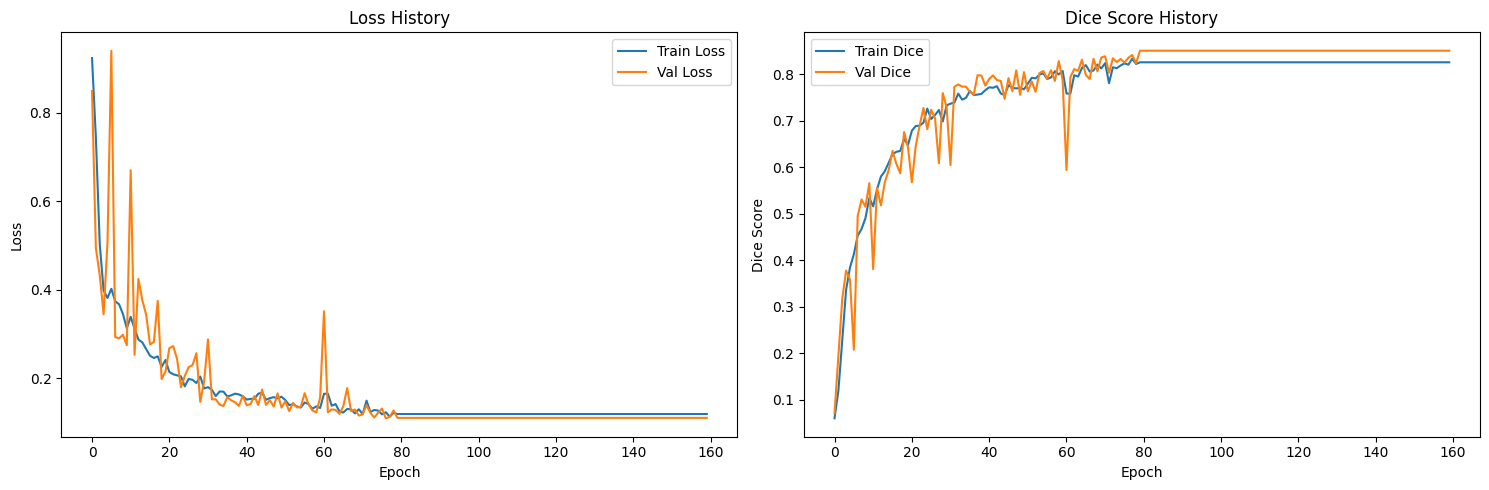

In [37]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    def ensure_numpy(data):
        """Convert any tensor/list to numpy array"""
        if torch.is_tensor(data):
            return data.cpu().numpy()
        elif isinstance(data, list):
            return np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in data])
        return np.array(data)
    
    # Process and plot loss history
    train_loss = ensure_numpy(history['train_loss'])
    val_loss = ensure_numpy(history['val_loss'])
    ax1.plot(train_loss, label='Train Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Process and plot Dice score history
    train_dice = ensure_numpy(history['train_dice'])
    val_dice = ensure_numpy(history['val_dice'])
    ax2.plot(train_dice, label='Train Dice')
    ax2.plot(val_dice, label='Val Dice')
    ax2.set_title('Dice Score History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Score')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# And modify your training loop to store values properly:
for epoch in range(num_epochs):
    # ... training code ...
    
    # Store metrics properly
    def store_metric(value):
        if torch.is_tensor(value):
            return value.item() if value.numel() == 1 else value.cpu().numpy()
        return value
    
    history['train_loss'].append(store_metric(train_loss))
    history['train_dice'].append(store_metric(train_dice))
    history['val_loss'].append(store_metric(val_loss))
    history['val_dice'].append(store_metric(val_dice))

# Now plotting will work
plot_results(history)

## Prediction on Test set

In [38]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_metrics = {'precision': 0, 'recall': 0, 'f1': 0, 'iou': 0, 'dice': 0}
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            metrics = calculate_metrics(outputs, masks)
            
            for key in test_metrics:
                test_metrics[key] += metrics[key] * images.size(0)
    
    # Average across all batches
    for key in test_metrics:
        test_metrics[key] /= len(test_loader.dataset)
    
    return test_metrics

In [39]:
# Save final model after training
torch.save(model.state_dict(), 'fpn_final_model.pth')
print("Final model saved as 'fpn_final_model.pth'")


Final model saved as 'fpn_final_model.pth'


In [40]:
import torch

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reinitialize the model with same architecture
model = EnhancedFPN(n_classes=1)

# Load the weights saved from training (choose the correct file name)
model.load_state_dict(torch.load('fpn_final_model.pth', map_location=device))

# Move model to correct device
model.to(device)

# Set model to evaluation mode
model.eval()

print(" Model loaded successfully")


# Now, you can make predictions



 Model loaded successfully


/tmp/ipykernel_31/1685416149.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fpn_final_model.pth', map_location=device))


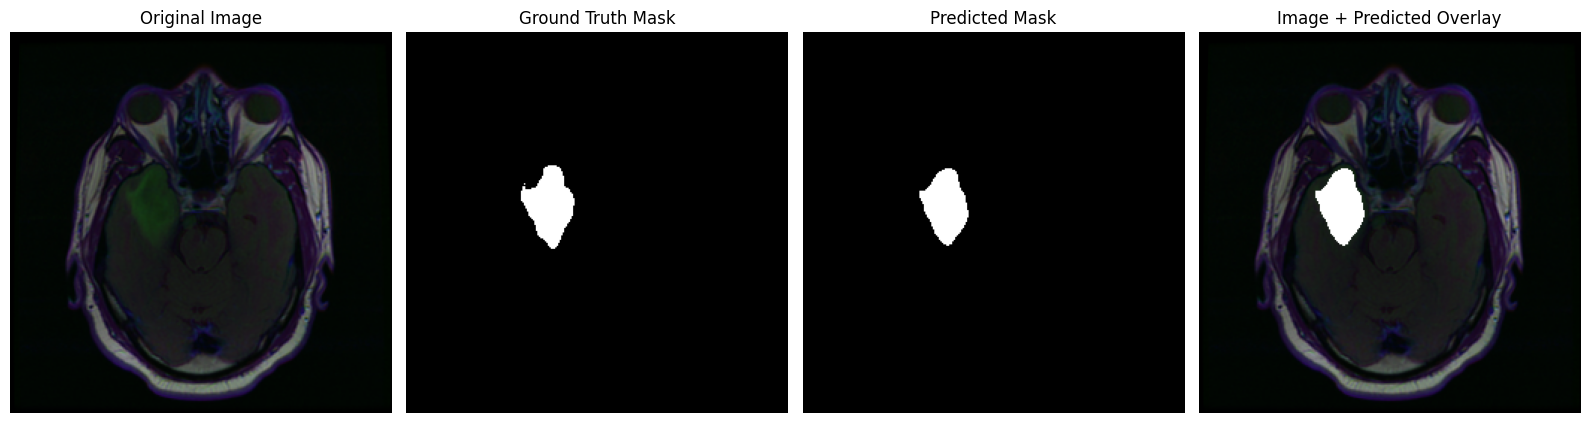

In [84]:
def predict_one_from_test(model, test_df, device):
    model.eval()

    # Select a random tumor image from test set
    sample = test_df[test_df['diagnosis'] == 1].sample(1).iloc[0]
    image_path = sample['image_path']
    mask_path = sample['mask_path']

    # Load image and mask
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize image and mask
    image_resized = cv2.resize(image_rgb, (256, 256))
    mask_resized = cv2.resize(mask, (256, 256))
    mask_binary = (mask_resized > 127).astype(np.uint8)

    # Apply transforms
    transformed = test_transform(image=image_resized, mask=mask_binary)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    mask_tensor = transformed['mask']

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        output_sigmoid = torch.sigmoid(output)
        pred_mask = output_sigmoid.squeeze().cpu().numpy()
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    # Create custom color masks with black background and tumor region as white
    gt_colored = np.zeros_like(image_resized)
    gt_colored[mask_binary == 1] = [255, 255, 255]  # White color for tumor region

    pred_colored = np.zeros_like(image_resized)
    pred_colored[pred_mask_bin == 1] = [255, 255, 255]  # White color for predicted tumor region

    # Overlay image and predicted mask
    overlay = np.copy(image_resized)
    overlay[pred_mask_bin == 1] = [255, 255, 255]  # Set tumor region to white in overlay

    # Plot results
    plt.figure(figsize=(16, 8))

    # Display original image
    plt.subplot(1, 4, 1)
    plt.imshow(image_resized)
    plt.title("Original Image")
    plt.axis("off")

    # Display ground truth mask
    plt.subplot(1, 4, 2)
    plt.imshow(gt_colored)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Display predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(pred_colored)
    plt.title("Predicted Mask")
    plt.axis("off")

    # Display overlay of image and predicted mask
    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Image + Predicted Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example Call
# Ensure you have the model, test_df, and device defined before running the function
predict_one_from_test(model, test_df, device)


/tmp/ipykernel_31/2332432406.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = torch.tensor(transformed['mask']).unsqueeze(0).to(device)


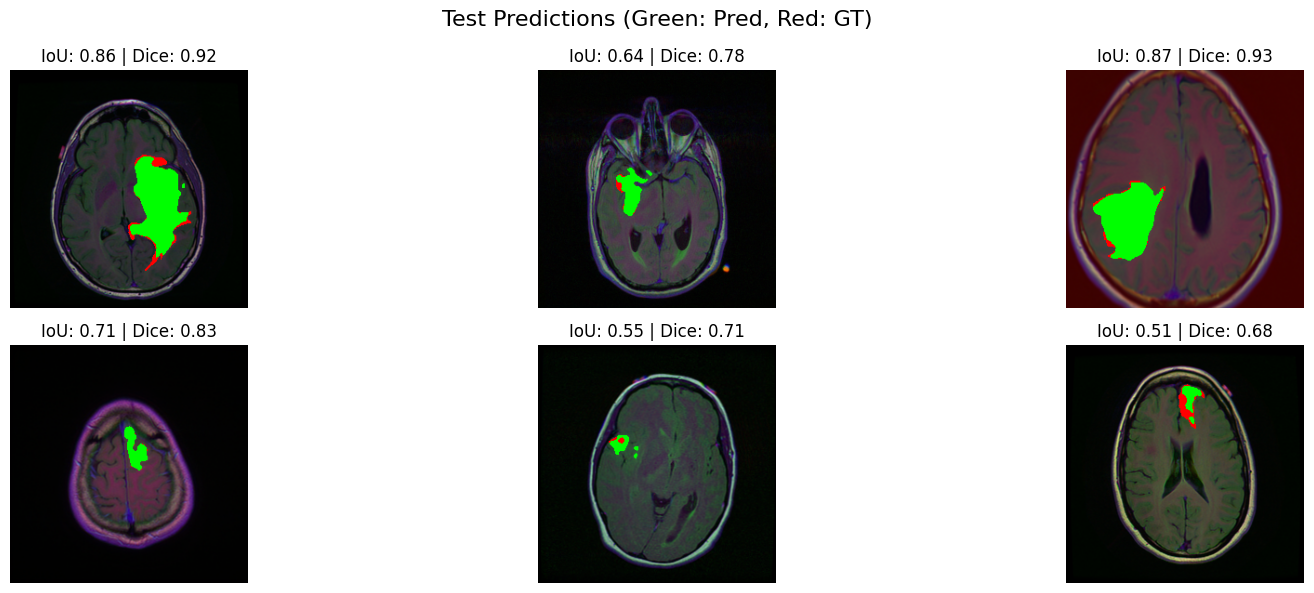

In [83]:
import matplotlib.patches as mpatches

def compute_iou(pred, target, eps=1e-7):
    pred = pred.bool()
    target = target.bool()
    intersection = (pred & target).sum().float()
    union = (pred | target).sum().float()
    return (intersection + eps) / (union + eps)

def predict_on_test(model, test_df, device, num_samples=6):
    model.eval()
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(18, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        sample = test_df[test_df['diagnosis'] == 1].sample(1).iloc[0]
        img = cv2.imread(sample['image_path'])
        img_rgb = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask_bin = (mask > 127).astype(np.uint8)

        # Preprocess
        transformed = val_transform(image=img_rgb, mask=mask_bin)
        image_tensor = transformed['image'].unsqueeze(0).to(device)
        gt_mask = torch.tensor(transformed['mask']).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_tensor)
            pred_sigmoid = torch.sigmoid(pred)
            pred_bin = (pred_sigmoid > 0.5).float()

        iou = compute_iou(pred_bin, gt_mask)
        dice = dice_score(pred_bin, gt_mask)

        # Overlay prediction & GT
        overlay = img_rgb.copy()
        pred_np = pred_bin.squeeze().cpu().numpy()
        gt_np = gt_mask.squeeze().cpu().numpy()
        overlay[gt_np == 1] = [255, 0, 0]      # Red = GT
        overlay[pred_np == 1] = [0, 255, 0]    # Green = Prediction

        axes[i].imshow(overlay)
        axes[i].set_title(f"IoU: {iou:.2f} | Dice: {dice:.2f}")
        axes[i].axis('off')

    plt.suptitle("Test Predictions (Green: Pred, Red: GT)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call this after training:
predict_on_test(model, test_df, device)


In [62]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_metrics = {'precision': [], 'recall': [], 'f1': [], 'iou': [], 'dice': []}

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.2).float()

            metrics = calculate_metrics(preds, masks)
            for k in all_metrics:
                # Ensure metrics are moved to CPU and converted to a scalar value if they are tensors
                all_metrics[k].append(metrics[k].cpu().item() if isinstance(metrics[k], torch.Tensor) else metrics[k])

    # Convert all metric lists to numpy arrays and compute their mean
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}

    print("\n=== Model Evaluation on Test Set ===")
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

evaluate_model(model, test_dl, device)



=== Model Evaluation on Test Set ===
Precision: 0.9192
Recall: 0.8886
F1: 0.9030
Iou: 0.8242
Dice: 0.9030


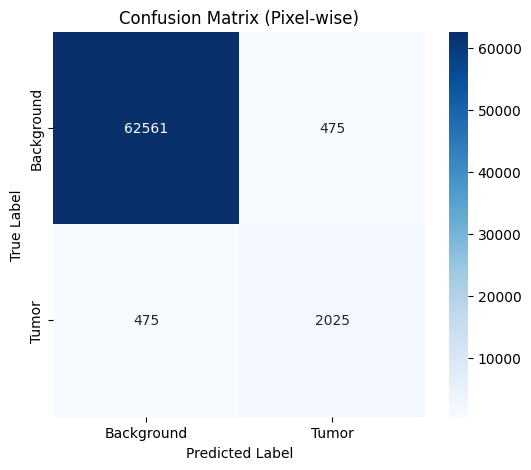

In [89]:
from sklearn.metrics import confusion_matrix

def compute_and_plot_confusion_matrix(gt_mask, pred_mask, threshold=0.5):
    """
    Computes and plots the confusion matrix for binary segmentation.
    
    Args:
        gt_mask (np.array): Ground truth mask (grayscale or binary, shape [H, W]).
        pred_mask (np.array): Predicted mask (float [0, 1] or binary, shape [H, W]).
        threshold (float): Threshold for binarizing predicted mask if it's not already binary.
    """
    # Flatten the masks
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()

    # Threshold if prediction is in float
    if pred_flat.max() <= 1.0:
        pred_flat = (pred_flat > threshold).astype(np.uint8)

    # Normalize ground truth if needed
    if gt_flat.max() > 1:
        gt_flat = (gt_flat > 127).astype(np.uint8)

    # Compute confusion matrix
    cm = confusion_matrix(gt_flat, pred_flat)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Background", "Tumor"],
                yticklabels=["Background", "Tumor"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Pixel-wise)")
    plt.show()

# Simulate dummy ground truth and prediction for testing
gt_mask = np.zeros((256, 256), dtype=np.uint8)
pred_mask = np.zeros((256, 256), dtype=np.float32)

# Add a fake tumor region (square) in both
gt_mask[50:100, 50:100] = 255
pred_mask[55:105, 55:105] = 1.0

# Call the function
compute_and_plot_confusion_matrix(gt_mask, pred_mask)



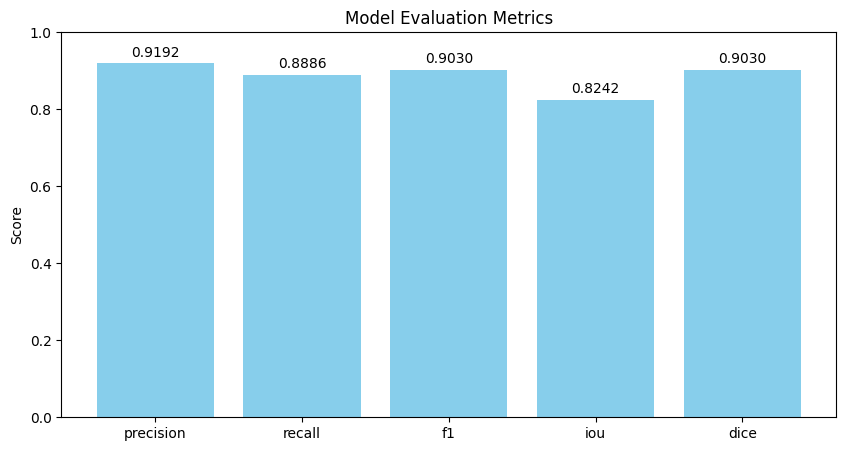

In [64]:
import matplotlib.pyplot as plt

def plot_evaluation_results(metrics_dict):
    metrics_names = list(metrics_dict.keys())
    values = [metrics_dict[k] for k in metrics_names]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(metrics_names, values, color='skyblue')
    plt.ylim(0, 1)
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Score")

    # Add values on top of bars
    for bar, val in zip(bars, values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{val:.4f}", ha='center', va='bottom')

    plt.show()

# Example usage
metrics = {
    'precision': 0.9192,
    'recall': 0.8886,
    'f1': 0.9030,
    'iou': 0.8242,
    'dice': 0.9030
}

plot_evaluation_results(metrics)

## prediction from data set ##

Ground truth mask shape: (256, 256)
Unique values in ground truth mask: [  0 255]


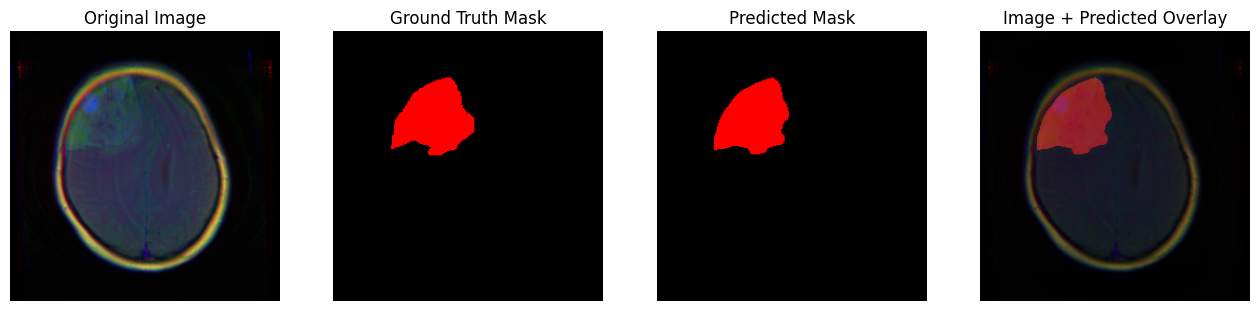

In [80]:
def predict_and_show_single_image(model, image_path, device, transform, gt_mask_path=None):
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_resized = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    
    # Dummy mask needed for transform
    dummy_mask = np.zeros((256, 256), dtype=np.uint8)
    transformed = transform(image=img_rgb, mask=dummy_mask)
    img_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Prediction
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

    # Load ground truth mask (if provided)
    gt_mask = None
    if gt_mask_path:
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None:
            raise FileNotFoundError(f"Ground truth mask not found at {gt_mask_path}")
        print(f"Ground truth mask shape: {gt_mask.shape}")
        
        # Check unique values in the mask to verify if it contains non-zero regions
        print(f"Unique values in ground truth mask: {np.unique(gt_mask)}")
        
        gt_mask_resized = cv2.resize(gt_mask, (256, 256))

    # Create custom color map for ground truth and predicted regions
    gt_colored = np.zeros_like(img_rgb)
    if gt_mask is not None:
        # Check if the ground truth mask has any tumor region (non-zero values)
        gt_colored[gt_mask_resized == 255] = [255, 0, 0]  # Red color for tumor region
    else:
        print("No valid ground truth mask to display.")
    
    pred_colored = np.zeros_like(img_rgb)
    pred_colored[pred_mask == 1] = [255, 0, 0]  # Red color for predicted tumor region

    # Plot the images
    plt.figure(figsize=(16, 16))
    
    # Display original image
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display ground truth mask if provided
    if gt_mask is not None:
        plt.subplot(1, 4, 2)
        plt.imshow(gt_colored)  # Ground truth mask with red for tumor
        plt.title("Ground Truth Mask")
        plt.axis('off')
    else:
        print("No valid ground truth mask to display.")
    
    # Display predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(pred_colored)  # Predicted mask in red
    plt.title("Predicted Mask")
    plt.axis('off')
    
    # Display overlay of predicted mask on the original image
    plt.subplot(1, 4, 4)
    plt.imshow(img_rgb)
    plt.imshow(pred_colored, alpha=0.5)  # Overlay the predicted red region
    plt.title("Image + Predicted Overlay")
    plt.axis('off')
    
    plt.show()

# Example call:
predict_and_show_single_image(model, "/kaggle/input/positiveimage/positive  image.tif", device, val_transform, "/kaggle/input/positiveimage/positive image mask.tif")


## Prediction from google image ##

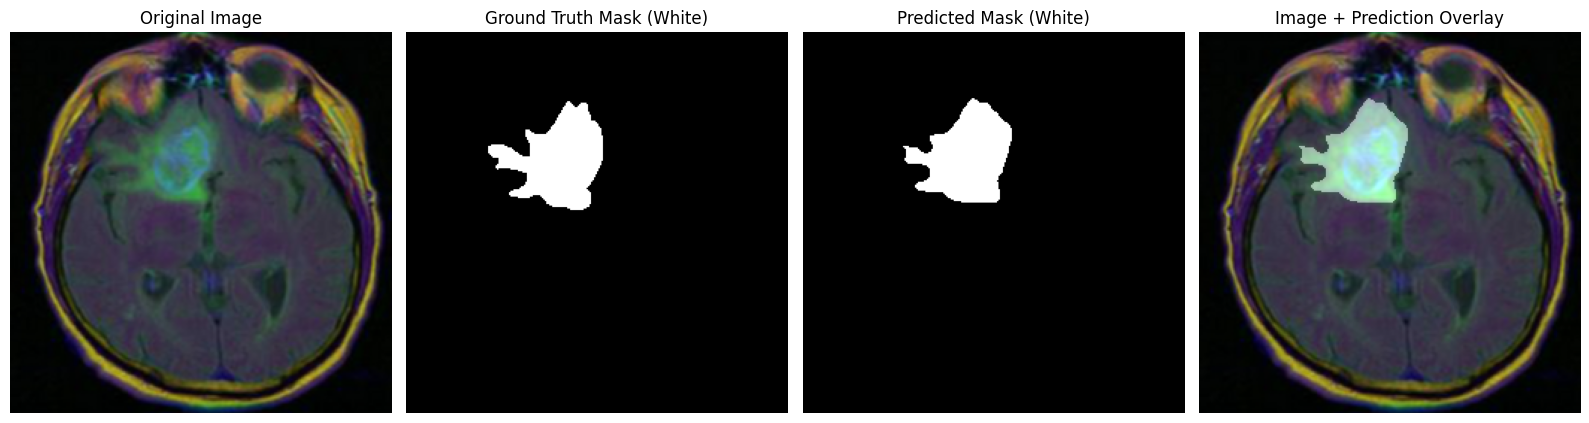

In [93]:
def predict_and_show_single_image(model, image_path, device, transform, gt_mask_path=None):
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_resized = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    
    # Dummy mask needed for transform
    dummy_mask = np.zeros((256, 256), dtype=np.uint8)
    transformed = transform(image=img_rgb, mask=dummy_mask)
    img_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Prediction
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

    # Load ground truth mask (if provided)
    gt_mask_resized = None
    if gt_mask_path:
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None:
            raise FileNotFoundError(f"Ground truth mask not found at {gt_mask_path}")
        gt_mask_resized = cv2.resize(gt_mask, (256, 256))
        gt_mask_binary = (gt_mask_resized > 127).astype(np.uint8)
    else:
        gt_mask_binary = None

    # Format ground truth: white tumor on black
    gt_colored = np.zeros((256, 256, 3), dtype=np.uint8)
    if gt_mask_binary is not None:
        gt_colored[gt_mask_binary == 1] = [255, 255, 255]  # white

    # Format prediction: white tumor on black
    pred_colored = np.zeros((256, 256, 3), dtype=np.uint8)
    pred_colored[pred_mask == 1] = [255, 255, 255]  # white

    # Overlay: white on top of image
    overlay = img_rgb.copy()
    white_overlay = np.zeros_like(img_rgb)
    white_overlay[pred_mask == 1] = [255, 255, 255]
    overlay = cv2.addWeighted(img_rgb, 1.0, white_overlay, 0.4, 0)

    # Plot the results
    plt.figure(figsize=(16, 16))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_colored)
    plt.title("Ground Truth Mask (White)")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_colored)
    plt.title("Predicted Mask (White)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Image + Prediction Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example call:
predict_and_show_single_image(
    model, 
    "/kaggle/input/positive/imagetwopositive.png", 
    device, 
    val_transform, 
    "/kaggle/input/positive/imagetwopositivemask.png"
)


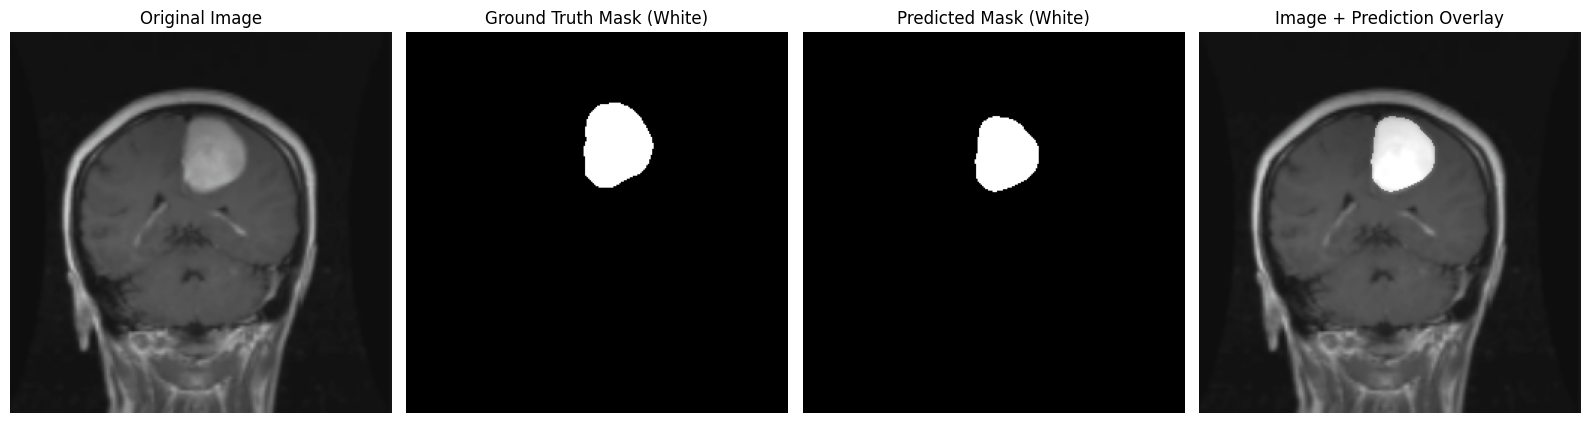

In [94]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_single_image(model, image_path, device, transform, gt_mask_path=None):
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_resized = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    
    # Dummy mask needed for transform
    dummy_mask = np.zeros((256, 256), dtype=np.uint8)
    transformed = transform(image=img_rgb, mask=dummy_mask)
    img_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Prediction
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

    # Load ground truth mask (if provided)
    gt_mask_resized = None
    if gt_mask_path:
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None:
            raise FileNotFoundError(f"Ground truth mask not found at {gt_mask_path}")
        gt_mask_resized = cv2.resize(gt_mask, (256, 256))
        gt_mask_binary = (gt_mask_resized > 127).astype(np.uint8)
    else:
        gt_mask_binary = None

    # Format ground truth: white tumor on black
    gt_colored = np.zeros((256, 256, 3), dtype=np.uint8)
    if gt_mask_binary is not None:
        gt_colored[gt_mask_binary == 1] = [255, 255, 255]  # white

    # Format prediction: white tumor on black
    pred_colored = np.zeros((256, 256, 3), dtype=np.uint8)
    pred_colored[pred_mask == 1] = [255, 255, 255]  # white

    # Overlay: white on top of image
    overlay = img_rgb.copy()
    white_overlay = np.zeros_like(img_rgb)
    white_overlay[pred_mask == 1] = [255, 255, 255]
    overlay = cv2.addWeighted(img_rgb, 1.0, white_overlay, 0.4, 0)

    # Plot the results
    plt.figure(figsize=(16, 16))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_colored)
    plt.title("Ground Truth Mask (White)")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_colored)
    plt.title("Predicted Mask (White)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Image + Prediction Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example call:
predict_and_show_single_image(
    model, 
    "/kaggle/input/thirdpositive/posimg.png", 
    device, 
    val_transform, 
    "/kaggle/input/thirdpositive/pos3mask.png"
)
